In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys

sys.path.append('tools')
import h5py
import pandas as pd
import copy
import numpy as np
import tensorflow as tf
import matplotlib
matplotlib.use("nbAgg")
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import layers, models, optimizers

import data_utility
import interactive_plot

### Import Data

In [3]:
path = 'data'

In [4]:
#data_import = data_utility.read_files(path = path, patientIDs = ['HUP084', 'HUP096'], verbose=True) # Import specified data by IDs
#data_import = data_utility.read_files(path = path, verbose=True) # Import all data
data_import = data_utility.read_files(path = path, annotation_only = True, verbose=True) # Import data with annotation

100%|██████████| 12/12 [00:21<00:00,  1.83s/it]


In [5]:
ids = list(data_import.keys())
ids #list of imported patient IDs

['HUP059',
 'HUP084',
 'HUP096',
 'HUP108',
 'HUP121',
 'HUP127',
 'HUP128',
 'HUP131',
 'HUP137',
 'HUP143',
 'HUP147',
 'HUP153']

### Data Display

In [6]:
id = ids[1]

In [7]:
data_import[id].catalog

,Patient ID,Timestamp,Session folder,Filename,ECoG type,ECoG trigger,ECoG length,Sampling rate,Waveform count,Ch 1 name,...,Ch 2 enabled,Ch 3 enabled,Ch 4 enabled,Raw UTC timestamp,Raw local timestamp,ECoG pre-trigger length,Event Start idx,Event End idx,Start UTC Timestamp,End UTC Timestamp
0,HUP084,2015-03-11 08:31:56.969,130705614608750000,130705616150800000.dat,Stored,Real_Time,92.252,250,4,LH1 - LH2,...,On,On,On,2015-03-11 15:33:29.221,2015-03-11 08:33:29.221,92.252,0,23063,1426087916969000,1426088009221000
1,HUP084,2015-03-11 08:44:35.040,130705614608750000,130705622939980000.dat,Stored,Real_Time,13.436,250,4,LH1 - LH2,...,On,On,On,2015-03-11 15:44:48.476,2015-03-11 08:44:48.476,13.436,23064,26423,1426088675040000,1426088688476000
2,HUP084,2015-03-11 14:59:05.464,130706402337760000,130706402674150000.dat,Stored,Scheduled,90.168,250,4,LH1 - LH2,...,On,On,On,2015-03-11 22:00:05.500,2015-03-11 15:00:05.500,60.036,26424,48965,1426111145464000,1426111235632000
3,HUP084,2015-03-12 01:59:05.964,130706402337760000,130706402939340000.dat,Stored,Scheduled,90.168,250,4,LH1 - LH2,...,On,On,On,2015-03-12 09:00:06.000,2015-03-12 02:00:06.000,60.036,48966,71507,1426150745964000,1426150836132000
4,HUP084,2015-03-13 01:58:59.476,130708551868440000,130708552220200000.dat,Stored,Scheduled,90.156,250,4,LH1 - LH2,...,On,On,On,2015-03-13 08:59:59.500,2015-03-13 01:59:59.500,60.024,71508,94046,1426237139476000,1426237229632000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4224,HUP084,2020-03-09 21:22:21.964,132283132682400000,132283133281940000.dat,Stored,Scheduled,90.156,250,4,LH1 - LH2,...,On,On,On,2020-03-10 04:23:22.000,2020-03-09 21:23:22.000,60.036,94334345,94356883,1583814141964000,1583814232120000
4225,HUP084,2020-03-10 10:22:16.964,132283984068210000,132283984409050000.dat,Stored,Scheduled,90.168,250,4,LH1 - LH2,...,On,On,On,2020-03-10 17:23:17.000,2020-03-10 10:23:17.000,60.036,94356884,94379425,1583860936964000,1583861027132000
4226,HUP084,2020-03-10 21:22:03.464,132283984068210000,132283984666580000.dat,Stored,Scheduled,90.168,250,4,LH1 - LH2,...,On,On,On,2020-03-11 04:23:03.500,2020-03-10 21:23:03.500,60.036,94379426,94401967,1583900523464000,1583900613632000
4227,HUP084,2020-03-11 10:21:59.464,132284858693750000,132284859029760000.dat,Stored,Scheduled,90.168,250,4,LH1 - LH2,...,On,On,On,2020-03-11 17:22:59.500,2020-03-11 10:22:59.500,60.036,94401968,94424509,1583947319464000,1583947409632000


In [8]:
data_import[id].annots

,Start UTC Time,End UTC Time,Annot Start Index,Annot End Index,Annot Length,Session Index,Description,Class
0,2015-03-18 14:55:46.396825,2015-03-18 14:55:55.056166,303527,305692,8.659341,14,"likely interictal, C1 very active ...",Non-Seizure
1,2015-03-23 21:41:08.561660,2015-03-23 21:42:34.528693,522350,543841,85.967033,24,C1>C2 ...,Unclear
2,2015-04-03 03:30:29.415946,2015-04-03 03:30:37.965396,1212183,1214321,8.549450,56,likely interictal ...,Non-Seizure
3,2015-04-06 22:10:37.371615,2015-04-06 22:10:45.734253,1479031,1481122,8.362638,68,likely interictal ...,Non-Seizure
4,2015-04-09 05:25:47.289726,2015-04-09 05:25:55.718298,1747448,1749555,8.428572,80,likely interictal ...,Non-Seizure
5,2015-04-16 10:02:40.214056,2015-04-16 10:02:55.609660,2300048,2303896,15.395604,107,likely interictal ...,Non-Seizure
6,2015-04-21 11:51:22.321814,2015-04-21 11:51:30.937199,2476977,2479131,8.615385,116,likely interictal ...,Non-Seizure
7,2015-05-29 01:04:19.781858,2015-05-29 01:04:26.452188,4671175,4672843,6.670330,222,likely interictal ...,Non-Seizure
8,2015-05-31 00:09:26.389353,2015-05-31 00:09:32.620122,4839039,4840596,6.230769,231,likely interictal - C1 very active ...,Non-Seizure
9,2015-06-03 17:34:18.663111,2015-06-03 17:34:26.289485,5177021,5178927,7.626374,246,stim given multiple times - possibly limiting ...,Seizure


In [9]:
data_import[id].plot_events(data_import[id].annots['Session Index'][:3])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Data Processing Demo

Set sliding window parameters and concatenation parameters

In [10]:
window_len = 2
stride = 2
concat_n = 5
data_import[id].set_window_parameter(window_length=window_len, window_displacement=stride)
data_import[id].set_concatenation_parameter(concatenate_window_n=concat_n)

Get windowed data, normalize data, concatenate data and get annotations of windowed data

In [11]:

data_import[id].get_windowed_data(data_import[id].annots["Annot Start Index"],
								  data_import[id].annots["Annot End Index"])
data_import[id].normalize_windowed_data()
_, concatenated_data = data_import[id].get_concatenated_data(data_import[id].windowed_data, arrange='channel_stack')
annot_map, color_map, type_map = data_import[id].get_windowed_annotation(class_n=2)

In [12]:
concatenated_data.shape

(113, 499, 44)

In [13]:
pca = PCA(n_components=2).fit_transform(concatenated_data.reshape((concatenated_data.shape[0],(concatenated_data.shape[1]*concatenated_data.shape[2]))))
p = np.vstack((pca[:,0], pca[:,1])).T

<IPython.core.display.Javascript object>


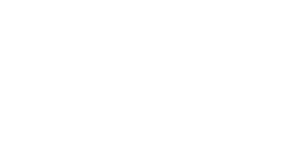

<IPython.core.display.Javascript object>


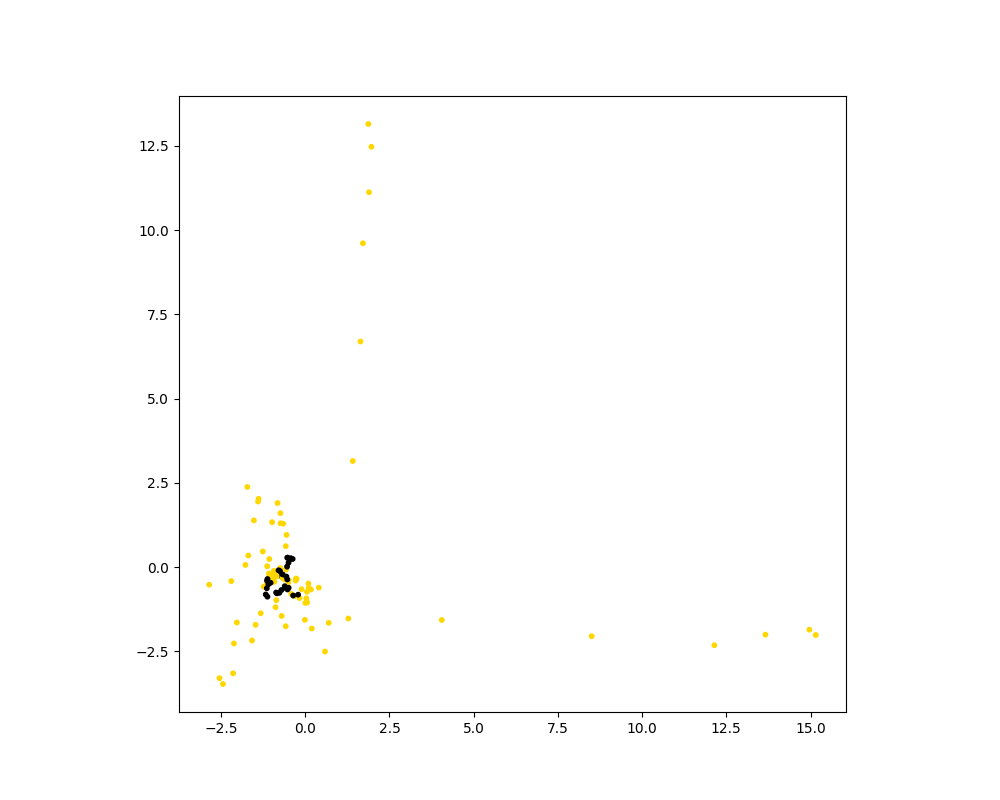

In [28]:
interactive_plot.interactive_plot(p,[id],data_import)